# Test RNN on IBDM as benchmark

In [1]:
!wget https://github.com/rasbt/python-machine-learning-book-3rd-edition/raw/master/ch08/movie_data.csv.gz

--2024-04-20 17:18:38--  https://github.com/rasbt/python-machine-learning-book-3rd-edition/raw/master/ch08/movie_data.csv.gz
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch08/movie_data.csv.gz [following]
--2024-04-20 17:18:39--  https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch08/movie_data.csv.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26521894 (25M) [application/octet-stream]
Saving to: ‘movie_data.csv.gz’

movie_data.csv.gz   100%[===================>]  25.29M  4.55MB/s    in 5.6s    

2

In [2]:
!gunzip -f movie_data.csv.gz 

In [1]:
import pandas as pd

In [3]:
#obtain review with highest amount of words
df = pd.read_csv('movie_data.csv')
df['review'] = df['review'].str.replace('<br />', ' ')
df['review'] = df['review'].str.split()
df['review_length'] = df['review'].apply(len)
df['review_length'].idxmax()

25114

In [2]:
df = pd.read_csv('movie_data.csv')
df.head()

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0


## prepare dataset

In [3]:
import torchtext
from sklearn.model_selection import train_test_split
import datautils
import torch

In [4]:
RANDOM_SEED = 123
torch.manual_seed(RANDOM_SEED)

VOCABULARY_SIZE = 20000
LEARNING_RATE = 0.005
BATCH_SIZE = 2048
NUM_EPOCHS = 30
DEVICE = datautils.get_device()

EMBEDDING_DIM = 128
HIDDEN_DIM = 256
NUM_CLASSES = 2

In [5]:
en_tokenizer = torchtext.data.utils.get_tokenizer(
    'spacy',
    language='en_core_web_sm',
    )

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size=0.2, random_state=RANDOM_SEED)
print(f'X_train: {len(X_train)}, X_test: {len(X_test)}')
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=RANDOM_SEED)
print(f'X_train: {len(X_train)}, X_val: {len(X_val)}')

X_train.reset_index(drop=True,inplace=True)
X_val.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
y_val.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

X_train: 40000, X_test: 10000
X_train: 34000, X_val: 6000


In [7]:
# build vocabulary on training set
curr_vocab = datautils.build_vocab(X_train, en_tokenizer,min_freq=18)
curr_vocab.set_default_index(curr_vocab["<unk>"])
len(curr_vocab)

19331

In [8]:


#process datasets
X_train = datautils.data_process(X_train, curr_vocab, en_tokenizer)
X_val = datautils.data_process(X_val, curr_vocab, en_tokenizer)
X_test = datautils.data_process(X_test, curr_vocab, en_tokenizer)

#create datasets for dataloader
train_dataset = datautils.TextDataset(X_train, y_train,curr_vocab)
val_dataset = datautils.TextDataset(X_val, y_val, curr_vocab)
test_dataset = datautils.TextDataset(X_test, y_test, curr_vocab)

In [9]:
# prepare dataloader
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=train_dataset.generate_batch,
)
val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=val_dataset.generate_batch,
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=test_dataset.generate_batch,
)


In [10]:
print('Train')
for batch in train_loader:
    print(f'Text matrix size: {batch[0].size()}')
    print(f'Target vector size: {batch[1].size()}')
    break
print('Val')
for batch in val_loader:
    print(f'Text matrix size: {batch[0].size()}')
    print(f'Target vector size: {batch[1].size()}')
    break
print('Test')
for batch in test_loader:
    print(f'Text matrix size: {batch[0].size()}')
    print(f'Target vector size: {batch[1].size()}')
    break

Train
Text matrix size: torch.Size([2048, 1827])
Target vector size: torch.Size([2048, 1])
Val
Text matrix size: torch.Size([2048, 2637])
Target vector size: torch.Size([2048, 1])
Test
Text matrix size: torch.Size([2048, 1411])
Target vector size: torch.Size([2048, 1])


In [11]:
import RNNutils

In [12]:
torch.manual_seed(RANDOM_SEED)
model = RNNutils.RNN(len(curr_vocab), EMBEDDING_DIM, HIDDEN_DIM)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.BCELoss()

In [13]:
for epoch in range(1, NUM_EPOCHS + 1):
    print(f'Epoch: {epoch}')
    train_loss = RNNutils.train_rnn(model, train_loader, optimizer, criterion,1)
    print(f'Evaluating...')
    val_loss , precision , recall, fscore = RNNutils.evaluate(model,val_loader,criterion)

    print(f'| Epoch: {epoch:02} | Train Loss: {train_loss:.3f} | Val Loss: {val_loss:.3f} | Precision: {precision:.2f} | Recall: {recall:.2f} | F1 Score: {fscore:.2f} |')

Epoch: 1
Evaluating...
| Epoch: 01 | Train Loss: 0.726 | Val Loss: 0.681 | Precision: 0.57 | Recall: 0.55 | F1 Score: 0.51 |
Epoch: 2
Evaluating...
| Epoch: 02 | Train Loss: 0.670 | Val Loss: 0.668 | Precision: 0.60 | Recall: 0.59 | F1 Score: 0.57 |
Epoch: 3
Evaluating...
| Epoch: 03 | Train Loss: 0.665 | Val Loss: 0.666 | Precision: 0.58 | Recall: 0.58 | F1 Score: 0.58 |
Epoch: 4
Evaluating...
| Epoch: 04 | Train Loss: 0.672 | Val Loss: 0.678 | Precision: 0.57 | Recall: 0.57 | F1 Score: 0.57 |
Epoch: 5
Evaluating...
| Epoch: 05 | Train Loss: 0.682 | Val Loss: 0.684 | Precision: 0.53 | Recall: 0.53 | F1 Score: 0.53 |
Epoch: 6
Evaluating...
| Epoch: 06 | Train Loss: 0.668 | Val Loss: 0.661 | Precision: 0.60 | Recall: 0.60 | F1 Score: 0.60 |
Epoch: 7
Evaluating...
| Epoch: 07 | Train Loss: 0.626 | Val Loss: 0.654 | Precision: 0.62 | Recall: 0.62 | F1 Score: 0.62 |
Epoch: 8
Evaluating...
| Epoch: 08 | Train Loss: 0.623 | Val Loss: 0.655 | Precision: 0.60 | Recall: 0.60 | F1 Score: 0.60 |


In [6]:
DEVICE

device(type='mps')

In [1]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Train and Validation Loss on IMDb dataset')

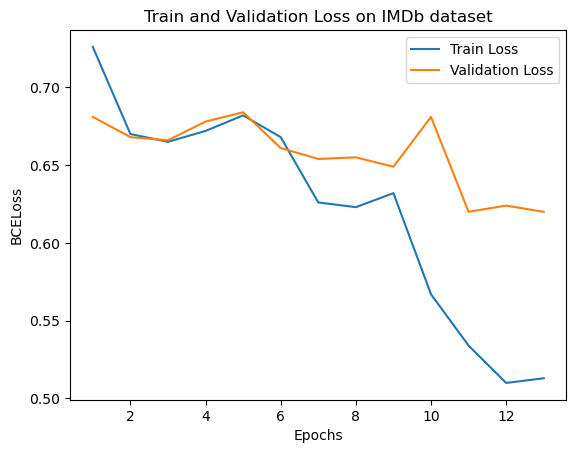

In [4]:
"""Epoch: 1
Evaluating...
| Epoch: 01 | Train Loss: 0.726 | Val Loss: 0.681 | Precision: 0.57 | Recall: 0.55 | F1 Score: 0.51 |
Epoch: 2
Evaluating...
| Epoch: 02 | Train Loss: 0.670 | Val Loss: 0.668 | Precision: 0.60 | Recall: 0.59 | F1 Score: 0.57 |
Epoch: 3
Evaluating...
| Epoch: 03 | Train Loss: 0.665 | Val Loss: 0.666 | Precision: 0.58 | Recall: 0.58 | F1 Score: 0.58 |
Epoch: 4
Evaluating...
| Epoch: 04 | Train Loss: 0.672 | Val Loss: 0.678 | Precision: 0.57 | Recall: 0.57 | F1 Score: 0.57 |
Epoch: 5
Evaluating...
| Epoch: 05 | Train Loss: 0.682 | Val Loss: 0.684 | Precision: 0.53 | Recall: 0.53 | F1 Score: 0.53 |
Epoch: 6
Evaluating...
| Epoch: 06 | Train Loss: 0.668 | Val Loss: 0.661 | Precision: 0.60 | Recall: 0.60 | F1 Score: 0.60 |
Epoch: 7
Evaluating...
| Epoch: 07 | Train Loss: 0.626 | Val Loss: 0.654 | Precision: 0.62 | Recall: 0.62 | F1 Score: 0.62 |
Epoch: 8
Evaluating...
| Epoch: 08 | Train Loss: 0.623 | Val Loss: 0.655 | Precision: 0.60 | Recall: 0.60 | F1 Score: 0.60 |
Epoch: 9
Evaluating...
| Epoch: 09 | Train Loss: 0.632 | Val Loss: 0.649 | Precision: 0.63 | Recall: 0.63 | F1 Score: 0.63 |
Epoch: 10
Evaluating...
| Epoch: 10 | Train Loss: 0.567 | Val Loss: 0.681 | Precision: 0.63 | Recall: 0.62 | F1 Score: 0.62 |
Epoch: 11
Evaluating...
| Epoch: 11 | Train Loss: 0.534 | Val Loss: 0.620 | Precision: 0.68 | Recall: 0.68 | F1 Score: 0.68 |
Epoch: 12
Evaluating...
| Epoch: 12 | Train Loss: 0.510 | Val Loss: 0.624 | Precision: 0.68 | Recall: 0.68 | F1 Score: 0.68 |
Epoch: 13
Evaluating...
| Epoch: 13 | Train Loss: 0.513 | Val Loss: 0.620 | Precision: 0.68 | Recall: 0.68 | F1 Score: 0.68 |"""

tr_loss_list = [0.726,0.670,0.665,0.672,0.682,0.668,0.626,0.623,0.632,0.567,0.534,0.510,0.513 ]
val_loss_list = [0.681,0.668,0.666,0.678,0.684,0.661,0.654,0.655,0.649,0.681,0.620,0.624,0.620]
epochs_list = [i for i in range(1,14)]

plt.plot(epochs_list,tr_loss_list, label='Train Loss')
plt.plot(epochs_list,val_loss_list, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('BCELoss')
plt.title('Train and Validation Loss on IMDb dataset')